# Imports

## Packages

In [ ]:
import torch.optim
from torch.utils import data
import argparse
import json
from tqdm import tqdm
import sys
import numpy
import clip
sys.path.append('/home/guest/Documents/Siraj TM/RSCaMa')
from model.model_encoder_attMamba import Encoder, AttentiveEncoder
from model.model_decoder import DecoderTransformer
from utils_tool.utils import *
from data.LEVIR_CC.LEVIRCC import LEVIRCCDataset
from torch import nn, einsum

from PIL import Image
from imageio import imread
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

import random

## Functions

In [2]:
def load_json(path):
    with open(path) as f:
        file = json.load(f)
    f.close()
    return file
def save_json(file,path):
    with open(path,'w') as f:
        json.dump(file,f)
    f.close()
    print("Saved Successfully")
def rem_print(word):
    t_word = word
    for _ in range(100 - len(t_word)):
        word = word + ' '
    print(word,end='\r')

## Data

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
word_vocab = load_json('assets/vocab.json')

Vocab = {key:word_vocab[key] for key in list(word_vocab.keys())[:468]}


# Analysis

In [10]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
encoder = Encoder('CLIP-ViT-B/32')
encoder_trans = AttentiveEncoder(n_layers=3,
                                        feature_size=[7, 7, 768],
                                        heads=8, dropout=0.1)
decoder = DecoderTransformer(decoder_type='transformer_decoder',embed_dim=768,
                                    vocab_size=len(Vocab), max_lengths=42,
                                    word_vocab=Vocab, n_head=8,
                                    n_layers=1, dropout=0.1)

checkpoint = torch.load('data/Pre-Trained Models/RSCaMa.pth',map_location=device)

encoder.load_state_dict(checkpoint['encoder_dict'])
encoder_trans.load_state_dict(checkpoint['encoder_trans_dict'])
decoder.load_state_dict(checkpoint['decoder_dict'])

encoder.eval()
encoder = encoder.cuda()
encoder_trans.eval()
encoder_trans = encoder_trans.cuda()
decoder.eval()
decoder = decoder.cuda()
print('load model success!')

decoder_n_layers= 1
decoder_type= transformer_decoder


FileNotFoundError: [Errno 2] No such file or directory: 'DATA/Pre-Trained Models/RSCaMa.pth'

# Data

In [ ]:
'''from zipfile import ZipFile 
with ZipFile("DATA/Levir-CC-dataset.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall( 
        path="DATA/Levir-CC-dataset")'''

In [16]:
Captions = load_json("data/Levir-CC-dataset/LevirCCcaptions.json")
test_path = 'data/Levir-CC-dataset/images/test'
invert = {val:key for key,val in word_vocab.items()}
except_tokens = {Vocab['<START>'], Vocab['<END>'], Vocab['<NULL>']}
except_tokens

{0, 2, 3}

In [18]:
def get_tokens(index):
    
    Path = 'data/Levir-CC-dataset/images/'
    Image_name = Captions['images'][index]['filename']
    dir_path = Path + '/' +  Captions['images'][index]['filepath']
    
    ImA =  f"{dir_path}/A/{Image_name}"
    ImB =  f"{dir_path}/B/{Image_name}"
       
    Ground_truth = Captions['images'][index]['sentences'][0]['raw']
    
    IMA = preprocess(Image.fromarray(
        io.imread(ImA)
        )).unsqueeze(0).to(device)
    
    IMB = preprocess(Image.fromarray(
        io.imread(ImB)
        )).unsqueeze(0).to(device)
    
    
    with torch.no_grad():
        feat1,feat2 = encoder(IMA,IMB)
        feat = encoder_trans(feat1,feat2)
        seq = decoder.sample(feat,k=1)
        
    pred_seq = [w for w in seq if w not in except_tokens]
    caption = [invert[token] for token in pred_seq]
    
    output = ''
    for word in caption:
        output += word + ' '
        
    print(f"Predicted_Caption : {output}\tGround Truth : {Ground_truth} ")

    fig,axes = plt.subplots(1,2)
    axes[0].set_title(f"Before - Index:{index}")
    axes[0].imshow(np.asarray(Image.open(ImA)))
    axes[0].axis('off')
    
    axes[1].set_title(f"After - Index:{index}")
    axes[1].imshow(np.asarray(Image.open(ImB)))
    axes[1].axis('off')
    plt.show()

/home/guest/anaconda3/envs/RSCaMa_env/lib/python3.9/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted_Caption : lined green along squares put places squares vehicles 	Ground Truth :  a t-shaped road in a residential area appears . 


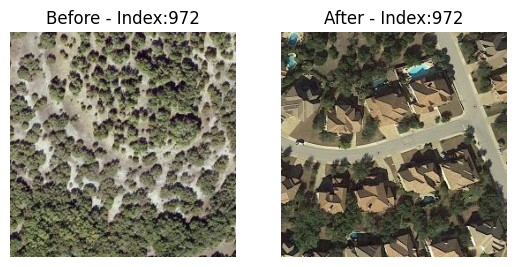

In [19]:
for index in [random.randint(0,1000) for _ in range(1)]:
    get_tokens(index)